## Importing Libraries

In [1]:
#!pip install pandas-datareader
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math

In [2]:
key = '8ab85204cc4ce8c7a6c14bffff1d2883fe14f9e9'
df = pdr.get_data_tiingo('AAPL', api_key = key)

C:\Users\Dnyandeep\anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [3]:
df.to_csv('AAPL.csv')

In [4]:
df = pd.read_csv('AAPL.csv')

In [5]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-07-19 00:00:00+00:00,151.02,151.42,149.95,150.48,20615419,35.734893,35.829543,35.481706,35.607116,82461676,0.0,1.0
1,AAPL,2017-07-20 00:00:00+00:00,150.34,151.74,150.19,151.50,17053326,35.573989,35.905262,35.538496,35.848473,68213304,0.0,1.0
2,AAPL,2017-07-21 00:00:00+00:00,150.27,150.44,148.88,149.99,24671002,35.557426,35.597652,35.228519,35.491171,98684008,0.0,1.0
3,AAPL,2017-07-24 00:00:00+00:00,152.09,152.44,149.90,150.58,21122730,35.988080,36.070899,35.469875,35.630779,84490920,0.0,1.0
4,AAPL,2017-07-25 00:00:00+00:00,152.74,153.84,151.80,151.80,18612649,36.141886,36.402172,35.919460,35.919460,74450596,0.0,1.0


In [6]:
df2 = df.reset_index()['close']

In [7]:
df2.shape

(1257,)

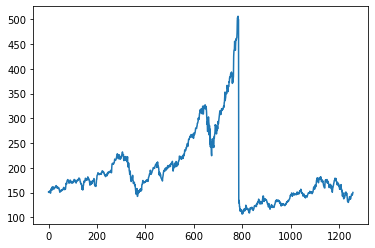

In [8]:
plt.plot(df2)
plt.show()

In [9]:
#Since, LSTM is sensitive to the scale of the data. We'll be applying MinMax scaler to it.

In [10]:
scaler = MinMaxScaler(feature_range= (0, 1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1, 1))

In [11]:
df2.shape

(1257, 1)

In [12]:
df2

array([[0.11065748],
       [0.10895429],
       [0.10877896],
       ...,
       [0.09680651],
       [0.10427051],
       [0.10852849]])

## Train, Test and Split

In [13]:
training_size = int(len(df2)*0.65)
test_size = len(df2) - training_size
train_data, test_data = df2[0:training_size, :], df2[training_size: len(df2) , :1]

In [14]:
train_data.shape, test_data.shape

((817, 1), (440, 1))

In [15]:
#Convert an array of values into a dataset matrix

def create_dataset(dataset, time_step= 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i: (i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
    

In [16]:
# Reshape into X = t, t+1, t+2, t+3 and Y = t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
print(X_train)

[[0.11065748 0.10895429 0.10877896 ... 0.15729493 0.15571697 0.15649343]
 [0.10895429 0.10877896 0.11333751 ... 0.15571697 0.15649343 0.15661866]
 [0.10877896 0.11333751 0.11496556 ... 0.15649343 0.15661866 0.16488416]
 ...
 [0.51671885 0.53197245 0.52601127 ... 0.01582968 0.0206387  0.02036318]
 [0.53197245 0.52601127 0.53112085 ... 0.0206387  0.02036318 0.02537257]
 [0.52601127 0.53112085 0.52571071 ... 0.02036318 0.02537257 0.04398247]]


In [18]:
#Reshape input to be [Samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Creating the LSTM Model

In [19]:
model= Sequential()
model.add(LSTM(50, return_sequences= True, input_shape = (100, 1)))
model.add(LSTM(50, return_sequences= True))
model.add((LSTM(50)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 100, batch_size = 64, verbose= 1)

Epoch 1/100
12/12 [==============================] - 7s 219ms/step - loss: 0.0431 - val_loss: 0.0012
Epoch 2/100
12/12 [==============================] - 1s 98ms/step - loss: 0.0180 - val_loss: 0.0095
Epoch 3/100
12/12 [==============================] - 1s 105ms/step - loss: 0.0130 - val_loss: 7.7577e-04
Epoch 4/100
12/12 [==============================] - 1s 96ms/step - loss: 0.0103 - val_loss: 0.0019
Epoch 5/100
12/12 [==============================] - 1s 96ms/step - loss: 0.0094 - val_loss: 3.2311e-04
Epoch 6/100
12/12 [==============================] - 1s 101ms/step - loss: 0.0083 - val_loss: 6.3311e-04
Epoch 7/100
12/12 [==============================] - 1s 92ms/step - loss: 0.0074 - val_loss: 2.7995e-04
Epoch 8/100
12/12 [==============================] - 1s 101ms/step - loss: 0.0070 - val_loss: 2.7445e-04
Epoch 9/100
12/12 [==============================] - 1s 101ms/step - loss: 0.0065 - val_loss: 2.5306e-04
Epoch 10/100
12/12 [==============================] - 2s 164ms/step - l

Epoch 79/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0046 - val_loss: 5.0826e-04
Epoch 80/100
12/12 [==============================] - 1s 113ms/step - loss: 0.0032 - val_loss: 1.9929e-04
Epoch 81/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0021 - val_loss: 2.7910e-04
Epoch 82/100
12/12 [==============================] - 1s 112ms/step - loss: 0.0041 - val_loss: 1.7640e-04
Epoch 83/100
12/12 [==============================] - 1s 113ms/step - loss: 0.0034 - val_loss: 2.5423e-04
Epoch 84/100
12/12 [==============================] - 1s 120ms/step - loss: 0.0024 - val_loss: 3.3722e-04
Epoch 85/100
12/12 [==============================] - 1s 122ms/step - loss: 0.0022 - val_loss: 3.1114e-04
Epoch 86/100
12/12 [==============================] - 2s 131ms/step - loss: 0.0019 - val_loss: 1.7874e-04
Epoch 87/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0017 - val_loss: 1.9771e-04
Epoch 88/100
12/12 [==========================

## Predictions and Performance Matrices

In [22]:
train_predict= model.predict(X_train)
test_predict= model.predict(X_test)

11/11 [==============================] - 0s 21ms/step


In [23]:
#Tranforming the data to it's original form
train_predict= scaler.inverse_transform(train_predict)
test_predict= scaler.inverse_transform(test_predict)

In [24]:
#Calculating RMSE performance matrices
math.sqrt(mean_squared_error(y_train, train_predict))

238.8465161149089

In [25]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

155.54241614625434

## Plotting graphs

In [26]:
#Shift train predictions for plotting
look_back= 100
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :]= train_predict

In [27]:
#Shift test predictions for plotiing
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :]= np.nan
testPredictPlot[look_back: len(test_predict) + look_back, :]= test_predict

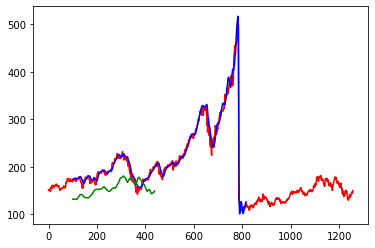

In [28]:
#Plot predictions and baseline
plt.plot(scaler.inverse_transform(df2), color= 'red')
plt.plot(trainPredictPlot, color= 'blue')
plt.plot(testPredictPlot, color= 'green')
plt.show()

In [29]:
len(test_data), len(train_data)

(440, 817)

In [30]:
x_input= test_data[340: ].reshape(1, -1)
x_input.shape

(1, 100)

In [31]:
temp_input= list(x_input)
temp_input= temp_input[0].tolist()

In [32]:
#Prediction for next 30 days
lst_output= []
n_steps= 100
i=0
while(i<30):
    if(len(temp_input)> 100):
        x_input= np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input= x_input.reshape(1, -1)
        x_input= x_input.reshape((1, n_steps, 1))
        #Print(x_input)
        yhat= model.predict(x_input, verbose= 0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input= temp_input[1: ]
        #Print(temp_input)
        lst_output.extend(yhat.tolist())
        i= i+1
    else:
        x_input= x_input.reshape((1, n_steps, 1))
        yhat= model.predict(x_input, verbose= 0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i= i+1
        
print(lst_output)

[0.11056133]
101
1 day input [0.13332498 0.14001252 0.14529743 0.1459737  0.14116468 0.14958046
 0.14875391 0.14108954 0.13139637 0.12673763 0.14053851 0.12944271
 0.11994991 0.1096556  0.1208516  0.13212273 0.13470257 0.14311835
 0.14662492 0.15524108 0.1587226  0.16839073 0.17001879 0.17222292
 0.1806387  0.17765811 0.16974327 0.16899186 0.17933626 0.17087038
 0.16278021 0.16355667 0.15842204 0.14755166 0.15233563 0.1591985
 0.1463995  0.14584847 0.15168441 0.15125861 0.14922981 0.13763306
 0.14036318 0.12513463 0.12455855 0.14226675 0.12726362 0.12804008
 0.13184721 0.14822793 0.12505949 0.12633688 0.11326237 0.11939887
 0.09933626 0.08946775 0.10086412 0.09693175 0.10619912 0.08510958
 0.07641828 0.07701941 0.09084534 0.08395742 0.08435817 0.09252348
 0.107201   0.10519724 0.10487163 0.11113338 0.096531   0.09843456
 0.10487163 0.10299311 0.08966813 0.07586725 0.0627176  0.06492173
 0.07160927 0.05815905 0.06191609 0.07271133 0.07140889 0.0787226
 0.08721353 0.08721353 0.07664371 0

9 day output [[0.13069677]]
10 day input [0.12673763 0.14053851 0.12944271 0.11994991 0.1096556  0.1208516
 0.13212273 0.13470257 0.14311835 0.14662492 0.15524108 0.1587226
 0.16839073 0.17001879 0.17222292 0.1806387  0.17765811 0.16974327
 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667 0.15842204
 0.14755166 0.15233563 0.1591985  0.1463995  0.14584847 0.15168441
 0.15125861 0.14922981 0.13763306 0.14036318 0.12513463 0.12455855
 0.14226675 0.12726362 0.12804008 0.13184721 0.14822793 0.12505949
 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775 0.10086412
 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941 0.09084534
 0.08395742 0.08435817 0.09252348 0.107201   0.10519724 0.10487163
 0.11113338 0.096531   0.09843456 0.10487163 0.10299311 0.08966813
 0.07586725 0.0627176  0.06492173 0.07160927 0.05815905 0.06191609
 0.07271133 0.07140889 0.0787226  0.08721353 0.08721353 0.07664371
 0.08112711 0.07484033 0.0803757  0.08696306 0.09036944 0.09896055
 0.10068879 0.0952536  

17 day output [[0.14619671]]
18 day input [0.14311835 0.14662492 0.15524108 0.1587226  0.16839073 0.17001879
 0.17222292 0.1806387  0.17765811 0.16974327 0.16899186 0.17933626
 0.17087038 0.16278021 0.16355667 0.15842204 0.14755166 0.15233563
 0.1591985  0.1463995  0.14584847 0.15168441 0.15125861 0.14922981
 0.13763306 0.14036318 0.12513463 0.12455855 0.14226675 0.12726362
 0.12804008 0.13184721 0.14822793 0.12505949 0.12633688 0.11326237
 0.11939887 0.09933626 0.08946775 0.10086412 0.09693175 0.10619912
 0.08510958 0.07641828 0.07701941 0.09084534 0.08395742 0.08435817
 0.09252348 0.107201   0.10519724 0.10487163 0.11113338 0.096531
 0.09843456 0.10487163 0.10299311 0.08966813 0.07586725 0.0627176
 0.06492173 0.07160927 0.05815905 0.06191609 0.07271133 0.07140889
 0.0787226  0.08721353 0.08721353 0.07664371 0.08112711 0.07484033
 0.0803757  0.08696306 0.09036944 0.09896055 0.10068879 0.0952536
 0.09773325 0.09680651 0.10427051 0.10852849 0.11056133 0.1126706
 0.11489955 0.11719365 0.

25 day output [[0.15929754]]
26 day input [0.17765811 0.16974327 0.16899186 0.17933626 0.17087038 0.16278021
 0.16355667 0.15842204 0.14755166 0.15233563 0.1591985  0.1463995
 0.14584847 0.15168441 0.15125861 0.14922981 0.13763306 0.14036318
 0.12513463 0.12455855 0.14226675 0.12726362 0.12804008 0.13184721
 0.14822793 0.12505949 0.12633688 0.11326237 0.11939887 0.09933626
 0.08946775 0.10086412 0.09693175 0.10619912 0.08510958 0.07641828
 0.07701941 0.09084534 0.08395742 0.08435817 0.09252348 0.107201
 0.10519724 0.10487163 0.11113338 0.096531   0.09843456 0.10487163
 0.10299311 0.08966813 0.07586725 0.0627176  0.06492173 0.07160927
 0.05815905 0.06191609 0.07271133 0.07140889 0.0787226  0.08721353
 0.08721353 0.07664371 0.08112711 0.07484033 0.0803757  0.08696306
 0.09036944 0.09896055 0.10068879 0.0952536  0.09773325 0.09680651
 0.10427051 0.10852849 0.11056133 0.1126706  0.11489955 0.11719365
 0.11951003 0.12181889 0.12410127 0.12634562 0.1285453  0.13069677
 0.13279863 0.13485068 

In [33]:
day_new= np.arange(1, 101)
day_pred= np.arange(101, 131)

In [34]:
len(df2)

1257

In [35]:
df3 = df2.tolist()
df3.extend(lst_output)

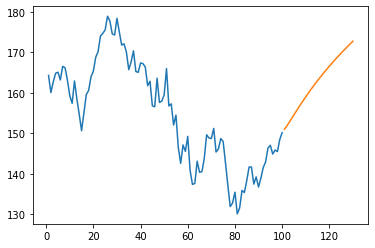

In [36]:
plt.plot(day_new, scaler.inverse_transform(df2[1157: ]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.show()

In [37]:
## Orange line shows the predictions for next 30-days

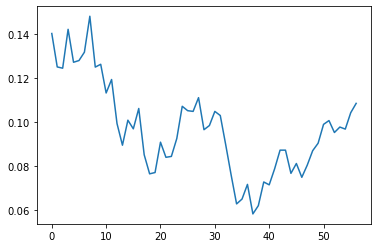

In [38]:
plt.plot(df2[1200: ])
plt.show()